![ll](https://preview.redd.it/12kjs65k2ah21.jpg?width=640&crop=smart&auto=webp&s=24b5dcf14075ff7c19e201514a6751770f71511a)

# Mission

According to ASHRAE,

> Assessing the value of energy efficiency improvements can be challenging as there's no way to truly know how much energy a building would have used without the improvements. The best we can do is to build counterfactual models. Once a building is overhauled the new (lower) energy consumption is compared against modeled values for the original building to calculate the savings from the retrofit. More accurate models could support better market incentives and enable lower cost financing.

Our task (yes, your and mine) is to embark on a quest to find such a suitable model. It will be used to predict the energy usages in buildings of various types all over the world for about 16 months, based on all their energy usage data from 2016. Besides various attributes of the buildings, this task obviously requires also weather data, as besides the time of day and week, weather is intuitively the most important determinant of energy use. Therefore the chosen buildings, of which there are over 9000, are clustered near 15 weather stations.

# Setting up

The code in this section is from this excellent kernel: https://www.kaggle.com/caesarlupum/ashrae-ligthgbm-simple-fe/notebook#7.-Handling-missing-values

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')
import gc

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import matplotlib.patches as patches
from scipy import stats
from scipy.stats import skew

from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
pd.set_option('max_columns', 100)

py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import os,random, math, psutil, pickle
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from tqdm import tqdm

from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation
from keras.optimizers import Adam, Adagrad
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

### Downloading and merging the training data

In [ ]:
def merge_meta(df, m_df):
    temp_df = df[['building_id']]
    temp_df = temp_df.merge(m_df, on=['building_id'], how='left')
    del temp_df['building_id']
    return pd.concat([df, temp_df], axis=1)

def merge_weather(df, w_df):
    temp_df = df[['site_id','timestamp']]
    temp_df = temp_df.merge(w_df, on=['site_id','timestamp'], how='left')
    del temp_df['site_id'], temp_df['timestamp']
    return pd.concat([df, temp_df], axis=1)

In [ ]:
building_meta_df = pd.read_csv("../input/ashrae-energy-prediction/building_metadata.csv")
train_df = pd.read_csv("../input/ashrae-energy-prediction/train.csv")
weather_train_df = pd.read_csv("../input/ashrae-energy-prediction/weather_train.csv")

In [ ]:
train_df = merge_meta(train_df, building_meta_df)
train_df = merge_weather(train_df, weather_train_df)

# Encoding

### Converting timestamps to datetimes

In [ ]:
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])

### Converting year built into age

In [ ]:
train_df['age'] = train_df['year_built'].max() - train_df['year_built'] + 1
train_df = train_df.drop('year_built', axis=1)

### Wind: En-compassing direction and Beau-tifying speed

In [ ]:
# Convert wind direction into categorical feature. We can split 360 degrees into 16-wind compass rose. 
# See this: https://en.wikipedia.org/wiki/Points_of_the_compass#16-wind_compass_rose
def rose_petalize(x):
    if np.isnan(x):
        return x
    else: 
        val=int((x/22.5))
        arr=[i for i in range(0,16)]
        return arr[(val % 16)]

# Since this is a cyclical variable, convert it to x and y on a circle.
# See this: http://blog.davidkaleko.com/feature-engineering-cyclical-features.html
def sinify_petals(X):
    return np.sin(X*(2.*np.pi/16))
def cosify_petals(X):
    return np.cos(X*(2.*np.pi/16))
    
train_df['wind_direction'] = train_df['wind_direction'].apply(rose_petalize)
train_df['wind_sin'] = sinify_petals(train_df['wind_speed'])
train_df['wind_cos'] = cosify_petals(train_df['wind_speed'])
#train_df = train_df.drop('wind_direction')

In [ ]:
beaufort = [(0, 0, 0.3), (1, 0.3, 1.6), (2, 1.6, 3.4), (3, 3.4, 5.5), (4, 5.5, 8), (5, 8, 10.8), (6, 10.8, 13.9), 
          (7, 13.9, 17.2), (8, 17.2, 20.8), (9, 20.8, 24.5), (10, 24.5, 28.5), (11, 28.5, 33), (12, 33, 200)]

# The original wind speed column is left in the dataframe, as it is 
# not certain that the new categorical alternative will be better. 
for item in beaufort:
    train_df.loc[(train_df['wind_speed']>=item[1]) & (train_df['wind_speed']<item[2]), 'beaufort_scale'] = item[0]

# Reducing memory usage

In [ ]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
train_df = reduce_mem_usage(train_df)

# Pickling

In [ ]:
train_df.to_pickle('train_df.pkl')
#test_df.to_pickle('test_df.pkl')

del train_df#, test_df
gc.collect()

![ll](https://vignette.wikia.nocookie.net/metroid/images/8/8a/Savestation.gif/revision/latest/scale-to-width-down/180?cb=20190728014411)

In [ ]:
train_df = pd.read_pickle('train_df.pkl')

# Exploration

### Energy usage distribution

In [ ]:
fig = plt.figure(figsize=(20,13))
for i, (name, meter_group) in enumerate(train_df.groupby('meter')):  
    ax = fig.add_subplot(2, 2, i+1)
    meter_group = meter_group[meter_group['meter_reading'] < 5000]
    sns.distplot(meter_group['meter_reading']).set_title('Distribution for meter {}'.format(name))

### Meter reading autocorrelation

In [ ]:
import statsmodels.api as sm

building_id = 500
data = train_df[train_df['building_id'] == building_id]
data = data[data['meter'] == 0]
fig = plt.figure(figsize=(20,6))
_ = sm.graphics.tsa.plot_pacf(data['meter_reading'], lags=300, ax=plt.gca())
plt.xlabel('Lag (hour)');
plt.ylabel('Autocorrelation');

There is very strong correlation with the previous hour's reading. There is also considerable negative correlation with the values at multiples of 24 h before.

### Building age

In [ ]:
id_df = train_df.groupby(['building_id']).mean()
sns.distplot(id_df['age'], bins = 15, kde = True, rug = False, norm_hist=False);

The most common age is around 50 years. We can also see that there are three primary categories of age: about 0 to 30, 30 to 75, and above 75. We should try to encode the age with these.

Next, lets look at the age distributions at each site.

In [ ]:
fig = plt.figure(figsize=(20,35))
fig.subplots_adjust(hspace=0.6, wspace=0.4)
n = 1
for name, site_group in train_df.groupby(['site_id']):
    ax = fig.add_subplot(8, 2, n)
    id_df = site_group.groupby(['building_id']).mean()
    nan_amount = id_df['age'].isnull().sum()
    nan_ratio = nan_amount / len(id_df)
    # Some out the sites that have no buildings with ages.
    if nan_ratio < 1:
        percent = np.around((1-nan_ratio)*100, 1)
        text = 'Site {}, {} buildings, of which {} percent have age.'.format(name, len(id_df), percent)
        sns.distplot(id_df['age'], bins = 15, kde = True, rug = False, norm_hist=False, ax=ax).set_title(text)
        n = n+1

Looking at the KDEs (the continuous lines), we see that the distribution of most sites is slightly skewed towards buildings less than 50 years old.

### Age vs. energy use

**A mean of all buildings, for each meter type.**


In [ ]:
fig = plt.figure(figsize=(20,13))
n = 1
for name, site_group in train_df.groupby('meter'):  # use enumerate
    ax = fig.add_subplot(2, 2, n)
    id_df = site_group.groupby(['building_id']).mean()
    id_df.plot(kind='scatter', x='age', y='meter_reading', color='red', alpha=0.4, title='Meter: {}'.format(name), ax=ax)
    n = n+1

The energy per area is quite independent of building age for all of the meters. However, for meters 0 and 1, there is a lot of noise for buildings newer than about 70 and 50 years respectively.

Note the singular outliers of meters 1 and 3. 

**All sites for meter 0**

Only meter 0 has enough data to warrant a sitewise analysis of the age vs. the meter reading:

In [ ]:
def plot_age_energy_sitewise(meter):
    fig = plt.figure(figsize=(15,40))
    fig.subplots_adjust(hspace=0.7)
    n = 1
    this_meter_df = train_df[train_df['meter'] == meter]
    for name, site_group_df in this_meter_df.groupby('site_id'):  # use enumerate
        buildings_df = site_group_df.groupby(['building_id']).mean()
        ax = fig.add_subplot(8, 2, n)
        buildings_df.plot(kind='scatter', x='age', y='meter_reading', color='red', alpha=0.4, title='Site: {}'.format(name), ax=ax)
        n = n+1
        
plot_age_energy_sitewise(0)

(The empty plots are sites that lack ages.) Again, there are no strong relationships; for most of them, newer buildings tend to have higher readings, but most buildings are at about the same level. The only interesting phenomenon is the distribution of site 5: the site could be some special region where many buildings have been intentionally opened on the same years. I fail to imagine what sort of district the latter could be. Most likely the stack are caused by slipshod data collection. 

### Primary use

**vs. energy usage**

In [ ]:
def use_energy_plot(df, meter):
    meter_df = df[df['meter'] == meter]
    
    temp_df = meter_df.copy()
    le = LabelEncoder()
    meter_df['primary_use'] = le.fit_transform(meter_df['primary_use']).astype(np.int8)
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    
    buildings_df = meter_df.groupby(['building_id']).mean()
    del temp_df
    
    plt.subplots(figsize = (10,7))
    sns.barplot(x = 'primary_use', 
                y = 'meter_reading', 
                data=buildings_df, 
                linewidth= 5,
                capsize = .1
               )
    plt.title("Energy usage vs. primary use for meter {}".format(meter), fontsize = 16, pad=20)
    plt.xticks(le.transform(le.classes_), le.classes_, rotation=90)
    plt.ylabel("Energy usage", fontsize = 15);
    plt.xlabel(None);

use_energy_plot(train_df, 0)
use_energy_plot(train_df, 1)
use_energy_plot(train_df, 2)
use_energy_plot(train_df, 3)

Meters 1, 2 and 3 have each one or two building uses with huge variances compared to the rest of the uses. Other than that, I am currently unable to extract any insights from these.

**vs. floor count**

In [ ]:
temp_df = train_df.copy()
le = LabelEncoder()
temp_df['primary_use'] = le.fit_transform(temp_df['primary_use']).astype(np.int8)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

buildings_df = temp_df.groupby(['building_id']).mean()
del temp_df

plt.subplots(figsize = (15,10))
sns.barplot(x = 'primary_use', 
            y = 'floor_count', 
            data=buildings_df, 
            linewidth=5,
            capsize = .1
           )
plt.title("Floor count vs. primary use", fontsize = 16, pad=20)
plt.xticks(le.transform(le.classes_), le.classes_, rotation=90)
plt.ylabel("Floor count", fontsize = 15);
plt.xlabel(None);

While somewhat interesting per se, this does not yield any insights for the feature engineering.

### Weather

Lets look at the relationships between weather features and the energy usage. Since many of the weather features are quite collinear, and there are so many that looking at all of their mutual interactions would take too much time and space, I will restrict this analysis to the relationship between the intuitively most important one, temperature and its relationship with intuitively second-most significant one, wind speed. (It is clear that across the four types of energy usage, the wind speed, precipitation etc. do not matter much if the air is at room temperature. Hence the temperature is the supreme weather variable.)

In [ ]:
# Optimizing by numpy-vectorization.

def closest_index(a,x):
    closest_index = np.abs(a-x).argmin()
    if a[closest_index] - x >= 0:
        return closest_index
    else:
        return min((closest_index + 1, len(a) - 1))

def weather_energy_matrix(df, feature):    
    temperature_bin_edges = range(int(df['air_temperature'].min()), int(df['air_temperature'].max()))
    feature_bin_edges = range(int(df[feature].min()), int(df[feature].max()))[1:]
    
    df = df[['meter_reading', 'air_temperature', feature]].dropna()
    X = df['meter_reading'].to_numpy()
    T = df['air_temperature'].to_numpy()
    F = df[feature].to_numpy()

    # Assigning each feature and temperature value into a bin (taking the upper bin edge).
    F_ = [closest_index(feature_bin_edges,f) for f in F]
    T_ = [closest_index(temperature_bin_edges,t) for t in T]
    shape = (len(temperature_bin_edges), len(feature_bin_edges))
    sums_matrix, counts_matrix = np.zeros(shape), np.zeros(shape)
    for x,t,f in zip(X,T_,F_):
        sums_matrix[t,f] += x 
        counts_matrix[t,f] += 1
    M = pd.DataFrame(data=sums_matrix/counts_matrix, index=temperature_bin_edges, columns=feature_bin_edges)
    return M
    
def plot_weather_energy_heatmaps(df, feature, meter):
    meter_df = df[df['meter'] == meter]
    n = 1
    fig = plt.figure(figsize=(40,60))
    fig.subplots_adjust(hspace=1)
    for site_id, site_group_df in meter_df.groupby('site_id'):
        M = weather_energy_matrix(site_group_df, feature)
        if ~M.isna().all().all():
            ax = fig.add_subplot(8, 2, n)
            sns.heatmap(M, cmap='Reds')
            ax.set_title('Meter {}, site {}'.format(meter, site_id))
            plt.xlabel(feature)
            plt.ylabel('Air temperature')
        label_freq = 3
        for ind, label in enumerate(ax.get_yticklabels()):
            label.set_visible((ind % label_freq) == 0)
        for ind, label in enumerate(ax.get_xticklabels()):
            label.set_visible((ind % label_freq) == 0)
        n += 1

In [ ]:
plot_weather_energy_heatmaps(train_df, 'beaufort_scale', 0)

In [ ]:
# This kernel takes too long to commit, so switched off.
'''
plot_weather_energy_heatmaps(train_df, 'wind_direction', 0)
'''

These yield no insights. Probably because there is so much variation between the time series of the different buildings that their mean values simply tend towards a the same value across the heatmap.

### Wind direction per hour of day

Copied from https://www.kaggle.com/chmaxx/ashrae-eda-and-visualization-wip#more-to-come...

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=4, sharex=True, sharey=True, figsize=(16, 12))
for sid in weather_train_df.site_id.unique():
    row = int(sid / 4)
    col = sid%4
    tmp_df = weather_train_df[weather_train_df.site_id==sid]
    tmp_df['timestamp'] = pd.to_datetime(tmp_df['timestamp'])
    tmp_df = tmp_df.set_index('timestamp')
    missing = 100 / len(tmp_df) * tmp_df['wind_direction'].isnull().sum()
    tmp_df.groupby(tmp_df.index.hour)['wind_direction'].median().plot(ax=axes[row,col])
    if missing !=0:
        axes[row, col].set_title(f"site {sid}, null:{missing :.2f}%", fontsize=12, color="darkred")
    else:
        axes[row, col].set_title(f"site {sid}", fontsize=12, color="darkgreen")
    axes[row, col].set_xlabel("")
fig.suptitle(f"wind_direction per hour of day", fontsize=18)
fig.subplots_adjust(top=0.92)

Any insights that would prove useful in the modeling? Perhaps, but lets leave that for later. Unless you really insist.

# Missing data

**Building metadata**

In [ ]:
import missingno as msno

df = pd.read_csv("../input/ashrae-energy-prediction/building_metadata.csv")
df['timestamp'] = pd.to_datetime(weather_train_df['timestamp'])
msno.matrix(df.set_index(['timestamp']))

**Weather at each site**

In [ ]:
weather_train_df = pd.read_csv("../input/ashrae-energy-prediction/weather_train.csv")
weather_train_df['timestamp'] = pd.to_datetime(weather_train_df['timestamp'])
weather_train_df = weather_train_df.set_index(['timestamp'])
for i in range(15):
    site_df = weather_train_df[weather_train_df['site_id'] == i]
    msno.matrix(site_df.iloc[:,1:], freq='M')

# Feature engineering

### Cyclical time features

In [ ]:
# I am not including the month in here, as the year should already be well covered by the week of year.
def cyc_time(df):
    df['hour_of_day'] = df['timestamp'].dt.hour.astype(np.int8)
    df['day_of_week'] = df['timestamp'].dt.dayofweek.astype(np.int8)
    df['week_of_year'] = df['timestamp'].dt.weekofyear.astype(np.int8)
    return df

train_df = cyc_time(train_df)

### Sinified cyclicals

This is needed for deep learning, but not for linear regression. [Here](http://blog.davidkaleko.com/feature-engineering-cyclical-features.html) is a great explanation of it.

In [ ]:
train_df['hour_sin'] = np.sin(train_df['hour_of_day']*(2.*np.pi/24))
train_df['hour_cos'] = np.cos(train_df['hour_of_day']*(2.*np.pi/24))

train_df['day_sin'] = np.sin(train_df['day_of_week']*(2.*np.pi/7))
train_df['day_cos'] = np.cos(train_df['day_of_week']*(2.*np.pi/7))

train_df['week_sin'] = np.sin(train_df['week_of_year']*(2.*np.pi/52))
train_df['week_cos'] = np.cos(train_df['week_of_year']*(2.*np.pi/52))

### Shifted series

I expect the temps and the wind speed to have moderate shifted correlation with the meter reading. Others not much.

In [ ]:
# Using numpy in addition to pandas due to the latter's slowness.

def shift_features(df, features, shift_n):
    print('Shifting {}'.format(features))
    total_values_array = np.empty((1,len(features)+1))
    for x, g in df.groupby(('building_id', 'meter')):
        
        shifted_features = g[features].shift(shift_n).to_numpy()
        shifted_features_with_index = np.column_stack((g.index, shifted_features))
        # Concatenating this building's data (as extra rows) to all the data.
        total_values_array = np.r_[total_values_array, shifted_features_with_index]
    
    # Exclude the first row, as it is the empty starting array.
    V = total_values_array[1:,:]
    
    # Sort rows according to index to match with dataframe's indices.
    V = V[V[:,0].argsort()]

    # Adding the data to the dataframe.
    for i, f in enumerate(features):
        df.loc[V[:,0].astype(int), 'shifted {} {}'.format(shift_n,f)] = V[:,i+1]    
    
    return df

In [ ]:
features_to_shift = [
                        'meter_reading',
                        'air_temperature',
                    ]


#train_df = shift_features(train_df, features_to_shift, 1)
#train_df = shift_features(train_df, features_to_shift, 2)
#train_df = shift_features(train_df, features_to_shift, 3)
#train_df = shift_features(train_df, features_to_shift, 4)

### STDs away from rolling mean

In [ ]:
# Getting the weather one as a separate function from the energy,
# as it is much faster to do it from the weather_df itself rather
# than the merged train_df.
def roll_weather(df, features, long_window, short_window):
    for x, g in df.groupby('site_id'):
        rolling_now = g[features].rolling(window=short_window, center=False).mean()
        rolling_mean = g[features].rolling(window=long_window, center=False).mean()
        rolling_std = g[features].rolling(window=long_window, center=False).std()
        target_values = ((rolling_now - rolling_mean) / rolling_std)
        df.loc[target_values.index, target_values.columns] = target_values
        return_df = df[features].add_prefix('rolling {}/{} '.format(short_window, long_window))
        return_df[['site_id', 'timestamp']] = df[['site_id', 'timestamp']]
        return_df['timestamp'] = pd.to_datetime(return_df['timestamp'])
        
        # Filling the first NaNs (left by the rolling) with the original data.
        return_df.loc[:long_window, features] = df.loc[:long_window, features]
    return return_df


    
# Using numpy in addition to pandas due to the latter's slowness.
def roll_energy(df, long_window, short_window):

    all_target_values = []
    all_index_values = []
    for x, g in df.groupby(('building_id', 'meter')):
        rolling_now = g['energy_per_area'].rolling(window=short_window, center=False).mean()
        rolling_mean = g['energy_per_area'].rolling(window=long_window, center=False).mean()
        rolling_std = g['energy_per_area'].rolling(window=long_window, center=False).std()
        target_values = ((rolling_now - rolling_mean) / rolling_std).to_numpy()
        
        # Filling the first NaNs (left by the rolling) with the original data.
        target_values[:long_window] = g.iloc[:long_window, df.columns.get_loc('energy_per_area')]
        
        all_target_values = np.append(all_target_values, target_values)
        all_index_values = np.append(all_index_values, g.index)
        
    V = np.column_stack((all_index_values, all_target_values))

    # Ordering the column of indices so that it would match with the dataframe.
    V = V[V[:,0].argsort()]
    
    col_name = 'rolling {}/{} energy per area'.format(short_window, long_window)
    df[col_name] = V[:,1]
    
    return df

In [ ]:
# Takes too long to commit this kernel, so switch off.
'''
long_window = 20
short_windows = [2]

# Using the original weather dataframe to do the rolling 
# due to the slowness of doing it for each building using the merged dataframe.
weather_features_to_roll = ['air_temperature', 'wind_speed', 'cloud_coverage', 'precip_depth_1_hr', 'sea_level_pressure']
    
for w in short_windows:
    train_df = roll_energy(train_df, long_window, w)
    rolled_weather = roll_weather(weather_train_df, weather_features_to_roll, long_window, w)
    train_df = merge_weather(train_df, rolled_weather) #pd.concat([train_df, rolled_weather], axis=1)
    
del weather_df
gc.collect()
'''

# Exploratory modeling

![ll](https://media.giphy.com/media/jKhxkINMo429G/giphy.gif)

### Trying a Keras Sequential model

In [ ]:
selected_features =  ['timestamp',
                     'shifted 1 meter_reading',
                     #'shifted 2 meter_reading',
                      #'shifted 3 meter_reading',
                      #'shifted 4 meter_reading',
                      'shifted 1 air_temperature',
                      #'shifted 2 air_temperature',
                      #'shifted 3 air_temperature',
                      #'shifted 4 air_temperature', 
                      'air_temperature',
                      'hour_sin', 'hour_cos', 
                      'day_sin', 'day_cos',
                      'week_sin', 'week_sin']

Setting up the data:

In [ ]:
def sequential_trial_sets():
    kfold = KFold(n_splits=5)
    cvscores = []
    b_id = 589
    n_hours = 600

    building_n_df = train_df[train_df['building_id'] == b_id][:n_hours]
    building_n_df = building_n_df[building_n_df['meter'] == 0]
    building_n_df = building_n_df[~building_n_df['meter_reading'].isna()].reset_index(drop=True)
    building_n_df = building_n_df[~building_n_df[selected_features].isna().any(axis=1)].reset_index(drop=True)

    y = building_n_df['meter_reading']
    X = building_n_df[selected_features]
    
    return X, y, train_test_split(X, y, test_size=0.3, random_state=3)

Making and trying the model:

In [ ]:
def try_sequential():
    X, y, (X_train, X_test, y_train, y_test) = sequential_trial_sets()
    all_dates = X['timestamp']
    test_dates = X_test['timestamp']
    X_train = X_train.drop('timestamp', axis=1)
    X_test = X_test.drop('timestamp', axis=1)

    model = Sequential(
            [
                Dense(50, activation="relu", input_dim=len(X_train.columns)),
                Dense(1, activation="linear")
            ]
        )
    model.compile(optimizer=Adam(), loss="mean_squared_error")
    model.fit(X_train, y_train, epochs=10, verbose=1)
    y_pred = model.predict(X_test)
    plt.figure(figsize=(16,5))
    plt.scatter(test_dates, y_pred, s=4, label='Predicted', alpha=1)
    plt.scatter(all_dates, y, color='r', s=13, label='Actual', alpha=0.2)
    plt.title('Predicted first {} hours for building {}'.format(n_hours, b_id))
    plt.legend()
    
#try_sequential()

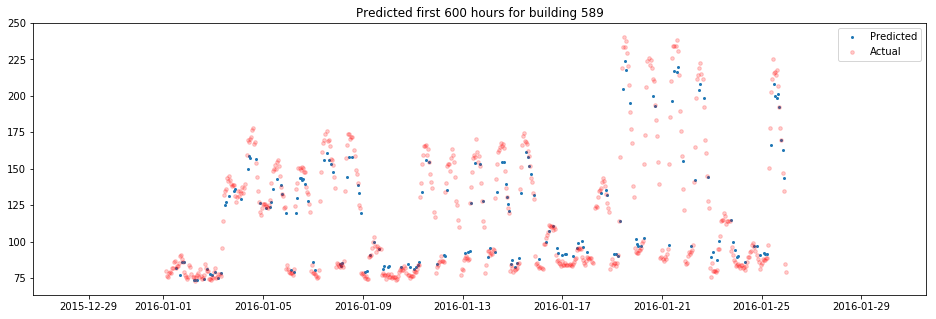

**<center>Looking promising.</center>**
![ll](https://media.giphy.com/media/YFis3URdQJ6qA/giphy.gif)

This is not a clear sign of victory, though: I have yet to find out how biased the model is towards the training set.

### Trying linear regression in LightGBM

Inspired by https://www.kaggle.com/caesarlupum/ashrae-ligthgbm-simple-fe/notebook#10.-Baseline

In [ ]:
le = LabelEncoder()
train_df['primary_use'] = le.fit_transform(train_df['primary_use']).astype(np.int8)

In [ ]:
categoricals = ["building_id",  "meter", 'day_of_week', 'week_of_year', 'hour_of_day']#, 'primary_use', 'hour_of_day']

numericals = ["air_temperature",
              #"dew_temperature",
              #'cloud_coverage',
              #'square_feet',
              #'floor_count'
             ]

shifted_numericals = ['shifted 1 meter_reading',
                      #'shifted 2 meter_reading',
                      #'shifted 3 meter_reading',
                      #'shifted 4 meter_reading',
                      'shifted 1 air_temperature',
                      #'shifted 2 air_temperature',
                      #'shifted 3 air_temperature',
                      #'shifted 4 air_temperature',
                     ] 
            

selected_features = categoricals + numericals + shifted_numericals

In [ ]:
params = {
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': {'rmse'},
            'subsample_freq': 1,
            'learning_rate': 0.3,
            'bagging_freq': 5,
            'num_leaves': 330,
            'feature_fraction': 0.9,
            'lambda_l1': 1,  
            'lambda_l2': 1
            }

Checking what the predictions look like:

In [ ]:
def gbm_trial_sets():
    building_n_df = train_df[train_df['building_id'] == b_id]
    building_n_df = building_n_df[building_n_df['meter'] == 0]

    y = building_n_df['meter_reading']
    X = building_n_df[selected_features + ['timestamp']]

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3) #split_data(X, y, 0.3)

    all_dates, val_dates = X['timestamp'], X_val['timestamp']
    X_train, X_val = X_train.drop('timestamp', axis=1), X_val.drop('timestamp', axis=1)
    
    return X_train, X_val, y_train, y_val

In [ ]:
def try_gbm():
    X_train, X_val, y_train, y_val = gbm_trial_sets()
    
    lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=categoricals)
    lgb_eval = lgb.Dataset(X_val, y_val, categorical_feature=categoricals)
    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=500,
                    valid_sets=(lgb_train, lgb_eval),
                    early_stopping_rounds=50,
                    verbose_eval = 50)
    y_pred = gbm.predict(X_val)

    plt.figure(figsize=(16,5))
    plt.scatter(val_dates, y_val, color='r', s=13, alpha=0.2)
    plt.scatter(val_dates, y_pred, s=2, alpha=1)
    x1,x2,y1,y2 = plt.axis()
    plt.axis(('2016-01-01 00:00:00', '2016-01-25 00:00:00', y1, y2))
    
#try_gbm()

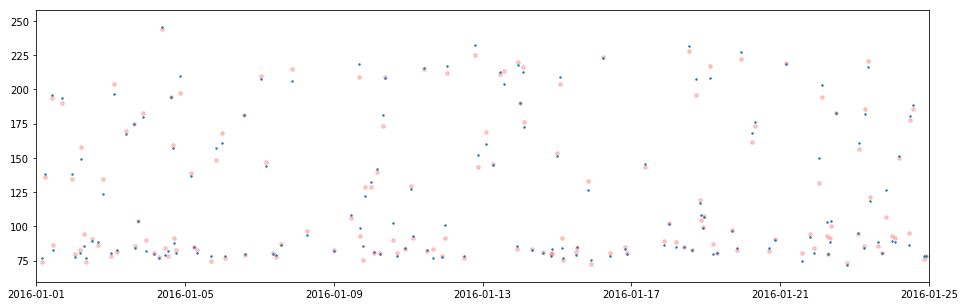

![ll](https://media.giphy.com/media/JTxQbJ5RMgVHi/giphy.gif)

# Feature selection

It is time to curate the optimal set of features from the ones given and the ones created above. I will use two approches: correlation, and backward elimination. 

### Correlation

In [ ]:
from scipy.stats import pearsonr, spearmanr

# Excluding the columns that are not weather or are cyclical.
features = train_df.columns.values[8:]
features = np.setdiff1d(features, ['energy_per_area', 
                                   'age', 
                                   'floor_count',
                                   'square_feet',
                                   'wind_direction', 
                                   'hour_of_day',
                                   'day_of_week',
                                   'week_of_year',
                                   'beaufort_scale',
                                   'wind_sin', 'wind_cos', 
                                   'hour_sin', 'hour_cos', 
                                   'day_sin', 'day_cos',
                                   'week_sin', 'week_cos'])

def multicollinearity(df):
    fig = plt.figure(figsize=(10,7))
    corr = df[features].corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, mask=mask, annot=False, cmap='PiYG')
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5) 

def meter_correlations(df, meter):
    data = df[df['meter'] == meter]
    all_corres = np.empty([1,len(features)])
    all_corres[:] = np.nan
    for i, g in data.groupby('building_id'):
        building_corres = []
        for f in features:
            feature_data = g[['meter_reading', f]]
            feature_data = feature_data[~feature_data[f].isna()]
            # Proceed only if there is sufficient data of this feature.
            sufficient_n = 200
            is_suf = (~feature_data[f].isna()).sum() > sufficient_n
            is_inf = any(np.isinf(feature_data[f]))
            if is_suf & ~is_inf:
                building_corres.append(pearsonr(feature_data['meter_reading'], feature_data[f])[0])
            else:
                building_corres.append(np.nan)
        all_corres = np.vstack((all_corres, building_corres))
    return np.nanmean(all_corres, axis=0)

In [ ]:
# I will just paste an image that I got before, using this same code, instead of
# lengthening the commit time by doing it again.
'''
corres = [meter_correlations(train_df, i) for i in range(4)]
fig, ax = plt.subplots(figsize=(20,5))
ax = sns.heatmap(corres, xticklabels=features, yticklabels=range(4), cmap='PiYG', annot=False, ax=ax, vmin=-1, vmax=1)
# Removing for the plot's truncation caused by matplotlib 3.1.1 
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5) 
'''

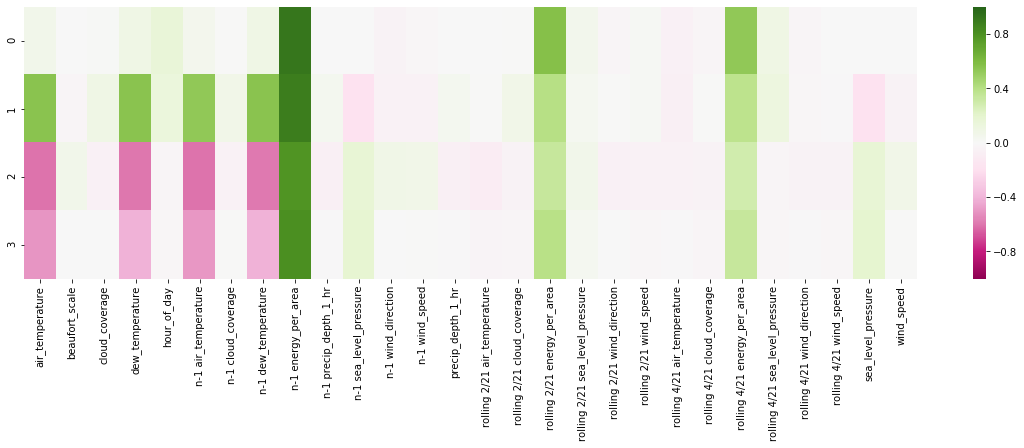

In [ ]:
multicollinearity(train_df)

**Notes on individual features**

*Dew temperature*: discard due to high collinearity with air temp.

*Cloud coverage*: a non-trivial case. On one hand, it seems that it should have a significant impact when the air temperature is high; after all, people yearn for shadow in summer heat. However, there is  no definite threshold above which it would be valid to use the cloud coverage. Using the actual function that relates cloud coverage (and radiation angle) to temperature and projected energy could of course bring big value to the model, but the point of this project is rather to find a heuristic model. In other words, though an intuitive comprehension of the underlying physics is indispensable for this mission, I shall refrain from the actual equations, and focus on learning data science. As such, taking into account the awful sparsity of the cloud coverage feature at most of the sites, it is best to drop it from the upcoming modeling.

*Cyclicals*: I did not include the cyclical features (wind direction, hour of day and period of year) here because correlation is not valid with them. However, the time-based ones must be significantly descriptive of the energy; this is apparent in the daily and yearly cycles of the series. The wind direction also could be important, as there are specific cold or hot winds in certain areas of the world (for example, in Europe when the wind is from the north, it is usually colder than otherwise, as it comes from Siberia). Although such heat or coldness is probably usually far better encapsulated in the air temperature, I suspect that the wind direction is worth trying.

**Choose our team:**

* n-1 energy

* Air temp

* Cyclicals: Hour of day, Day of week, and Week of year.

![ll](https://media.giphy.com/media/H5RSLry1qMrzq/giphy.gif)

### Backwards elimination

This process is cumulative, i.e., when a feature is marked with REMOVE, the ones after that are done with it removed. Each new RMSE score is hence compared to the last one marked with REMOVE.

In [ ]:
def backwards():
    y = train_df['meter_reading']
    X = train_df[selected_features]

    lgb_train = lgb.Dataset(X, y, categorical_feature=categoricals)
    del y, X
    gc.collect()

    history = lgb.cv(params,
                    lgb_train,
                    shuffle=True,
                    stratified=False,
                    nfold=5,
                    num_boost_round=500,
                    categorical_feature=categoricals,
                    early_stopping_rounds=30,
                    verbose_eval = 30)

    'Last RMSE: {}'.format(history['rmse-mean'][-1])

#backwards():

**With all:** 29553

**Without floor count:** 29716   REMOVE

**Without square feet:** 30025   REMOVE

**Without hour of day:**  27523  REMOVE

This is surprising, given the intuitively huge significance of the time of day for energy use.

**Without day of week:**   34521  KEEP   

**Without week of year:**  42546  KEEP 

**Withou cloud coverage:**   27273  REMOVE

**Without primary use**:    26958    REMOVE

**Without dew temperature:**   29371   KEEP

**Without shifted 4 air temperature:**  27791   KEEP

**Without shifted 4 meter reading:** 27323  KEEP


Here I have the issue of not knowing what threshold I should use for removing or keeping a feature. For example, the first increase in the RMSE above, when the floor count is removed, is only 0.6%. There must be a robust technique for finding the threshold.

# Modeling and prediction

### Preparing the testing set

Putting the testing set through the same functions as the training set.

In [ ]:
def prepare_test():
    test_df = pd.read_csv("../input/ashrae-energy-prediction/test.csv")
    building_meta_df = pd.read_csv("../input/ashrae-energy-prediction/building_metadata.csv")
    weather_test_df = pd.read_csv("../input/ashrae-energy-prediction/weather_test.csv")

    test_df = merge_meta(test_df, building_meta_df)
    test_df = merge_weather(test_df, weather_test_df)
    test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])
    test_df = cyc_time(test_df)

    features_to_shift = ['air_temperature']
    test_df = shift_features(test_df, features_to_shift, 1)
    #test_df = shift_features(test_df, features_to_shift, 2)
    #test_df = shift_features(test_df, features_to_shift, 3)
    #test_df = shift_features(test_df, features_to_shift, 4)
    
    test_df = reduce_mem_usage(test_df)
    test_df.to_pickle('test_df.pkl')
    gc.collect()
    
    return test_df

In [ ]:
#test_df = prepare_test()
#test_df = pd.read_pickle('test_df.pkl')

### Defining the model

Since LightGBM cannot be used as a base estimator in BaggingRegressor (as it does not belong to scikit), it has to be bagged manually.

As I want to maximize regularization, I will use only the validation set as the LightGBM's validation set, not the training set too.

In [ ]:
def gbm_bag(df, features, cats):
    folds = 5
    seed = 387
    kf = KFold(n_splits=folds, shuffle=True, random_state=seed)
    models = []
    i=0
    for train_index, val_index in kf.split(df[features], df['building_id']):
        i += 1
        #print('Fold {}'.format(i))
        train_X, val_X = df.loc[train_index, features], df.loc[val_index, features]
        train_y, val_y = df.loc[train_index, 'meter_reading'], df.loc[val_index, 'meter_reading']
        #train_y, val_y = np.log1p(df.loc[train_index, 'meter_reading']), np.log1p(df.loc[val_index, 'meter_reading'])
        lgb_train = lgb.Dataset(train_X, train_y, categorical_feature=cats)
        lgb_val = lgb.Dataset(val_X, val_y)
        gbm = lgb.train(params,
                        lgb_train,
                        num_boost_round=500,
                        valid_sets=lgb_val,
                        early_stopping_rounds=30,
                        verbose_eval = -1)
        models.append(gbm)
    return models

In [ ]:
def bagging_predict(bag, X):
    return np.mean([model.predict(X) for model in bag]) 

### Predicting with a separate model for each building

In backwards elimination above, I did not use this method, but the in the next subsection; this method takes such a long time to finish that I have not enough time to conduct the backwards elimination process with this. As such, I shall instead use the set of 5 features chosen in the alternative feature selection approach, namely the correlation analysis.

In [ ]:
categoricals = ['day_of_week', 'week_of_year', 'hour_of_day']
numericals = ["air_temperature"]
shifted_numericals = ['shifted 1 meter_reading'] 

train_df_features = categoricals + numericals + shifted_numericals
test_df_features = categoricals + numericals

In [ ]:
scores = []

def train_predict_separately():
    for (_, train_g), (i, test_g) in zip(train_df.groupby(['building_id', 'meter']), test_df.groupby(['building_id', 'meter'])):

        # This if is useful when having to stop and restart this script.
        if (i[0] > -1):
            print('Building {}'.format(i))

            bag = gbm_bag(train_g.reset_index(), train_df_features, categoricals[2:])
            scores.append([m.best_score for m in bag])

            energy_shifts = 1
            temperature_shifts = 1
            preds = np.array([])

            # Adding the last values from the previous year into the preds array,  
            # as they are the shifted values of the first values of the new year.
            start_energies = train_g.loc[train_g.index[-energy_shifts:], 'meter_reading'] #np.log1p(train_g.loc[train_g.index[-energy_shifts:], 'meter_reading']) 
            start_temperatures = train_g.loc[train_g.index[-temperature_shifts:], 'air_temperature']
            preds = np.concatenate((preds, start_energies))
            temperatures = np.append(start_temperatures.to_numpy(), test_g['air_temperature'].to_numpy())

            # Iterating over the numpy array instead of using g.iterrows(),
            # as the latter is too slow.
            for j, row in enumerate(test_g[test_df_features].to_numpy()):

                shifted_energies = preds[-energy_shifts:]
                shifted_temperatures = temperatures[j:j+temperature_shifts]
                row = np.concatenate((row, shifted_energies))
                row = np.concatenate((row, shifted_temperatures))

                # Reshaping due to LightGBM's 2D array requirement.
                row = np.array(row).reshape((1,-1))
                preds = np.append(preds, bagging_predict(bag, row))

            test_df.loc[test_g.index, 'meter_reading'] = preds[energy_shifts:] #expm1(preds[energy_shifts:])

In [ ]:
# Takes too long to commit with this, so flipped off.
'''
train_predict_separately()

# Mean score from validation sets.
print(np.mean([X[0]['valid_0'].popitem()[1] for X in scores]))

test_df = reduce_mem_usage(test_df)
test_df.to_pickle('test_df.pkl')
gc.collect()
'''

Before submitting, lets check whether the predictions at least *could* be accurate by comparing the form of one building's prediction to that of its readings during the equivalent timeframe in the previous year. This will give an intuitive sense of its bias and variance. 

In [ ]:
from dateutil.relativedelta import relativedelta

def test_for_building(b_id):
    train_building_df = train_df[(train_df['building_id'] == b_id) & (train_df['meter'] == 0)]
    test_building_df = test_df[(test_df['building_id'] == b_id) & (test_df['meter'] == 0)]

    train_building_df = train_building_df.set_index('timestamp')['2016-04-01 00:00:00' : '2016-07-01 00:00:00']
    test_building_df = test_building_df.set_index('timestamp')['2017-04-01 00:00:00' : '2017-07-01 00:00:00']

    plt.figure(figsize=(16,4))
    plt.scatter(train_building_df.index, train_building_df['meter_reading'], c='r', s=13, alpha=0.2,)
    plt.scatter([ x - relativedelta(years=1) for x in test_building_df.index ], test_building_df['meter_reading'], s=2, alpha=1)

In [ ]:
'''
test_for_building(601)
'''

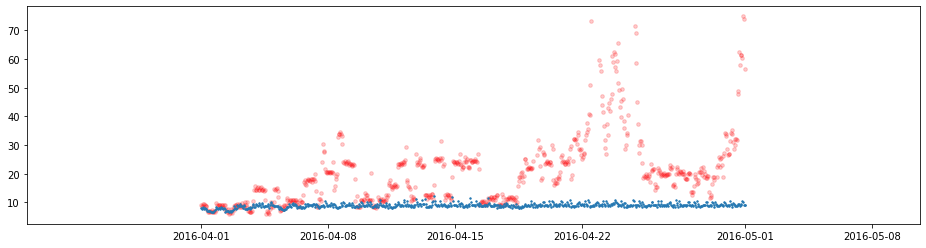

![ll](https://media.giphy.com/media/o14YPU6vooy0o/giphy.gif)

Awful! It turns out that the scaling of the target by log1p before training the model causes this naughty behavior, as it makes the values too small. Why do small values prevent proper regression? It is a mystery, one of the great questions of the universe.  

Here they are with the log1p removed (commented out and replaced with new lines above):
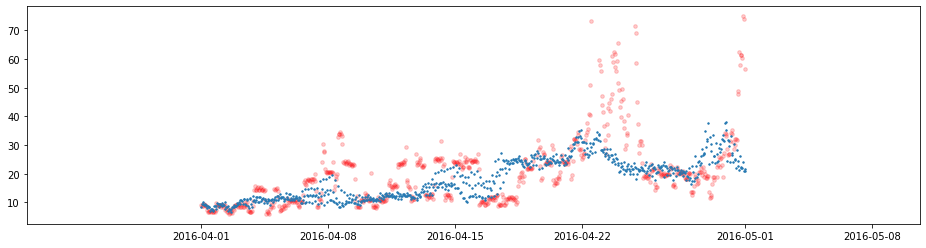

![ll](https://media.giphy.com/media/NJZMSqRY3rG9i/giphy.gif)

Note that performing the same without bagging, i.e., with a standard model for each building, would yield excessive bias, that is, low reguralization; it would be odd if the very same patterns truly repeated from year to year, like here:
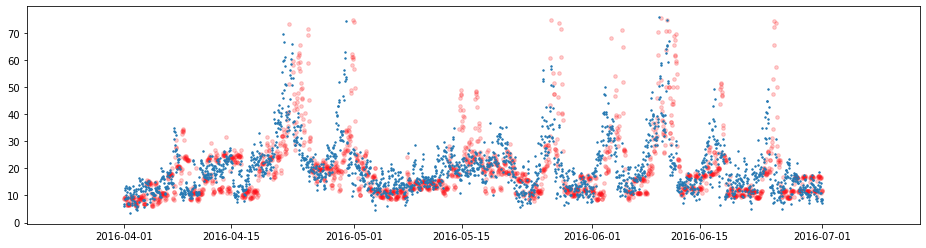

### Predicting with a single bag of models for the whole dataset

In [ ]:
train_df_features = categoricals + numericals + shifted_numericals
test_df_features = categoricals + numericals

In [ ]:
def train_predict_holistically():
    
    bag = gbm_bag(train_df, train_df_features, categoricals)
    
    for (_, train_g), (i, test_g) in zip(train_df.groupby(['building_id', 'meter']), test_df.groupby(['building_id', 'meter'])):
        if (i[0] > -1):
            print(i)
            energy_shifts = 1
            temperature_shifts = 1
            preds = np.array([])

            # Adding the last values from the previous year into the preds array,  
            # as they are the shifted values of the first values of the new year.
            start_energies = train_g.loc[train_g.index[-energy_shifts:], 'meter_reading'] 
            start_temperatures = train_g.loc[train_g.index[-temperature_shifts:], 'air_temperature']
            preds = np.concatenate((preds, start_energies))
            temperatures = np.append(start_temperatures.to_numpy(), test_g['air_temperature'].to_numpy())

            # Iterating over the numpy array instead of using g.iterrows(),
            # as the latter is too slow.
            for j, row in enumerate(test_g[test_df_features].to_numpy()):

                shifted_energies = preds[-energy_shifts:]
                shifted_temperatures = temperatures[j:j+temperature_shifts]
                row = np.concatenate((row, shifted_energies))
                row = np.concatenate((row, shifted_temperatures))

                # Reshaping due to LightGBM's 2D array requirement.
                row = np.array(row).reshape((1,-1))
                preds = np.append(preds, bagging_predict(bag, row))

            test_df.loc[test_g.index, 'meter_reading'] = preds[4:]

In [ ]:
'''
train_predict_holistically()
test_for_building(601)
'''

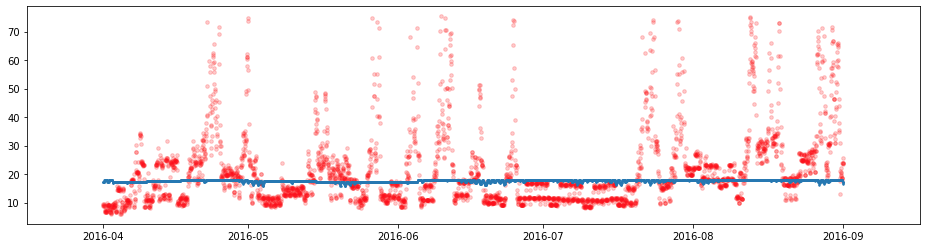

![ll](https://media.giphy.com/media/zXMRfbsHOAire/giphy.gif)

There are two possible reasons for this:
1. Linear regression cannot use the categorical feature Building ID to discern which building it is predicting for.
2. The various scales of the data for the buildings, i.e., some buildings have far smaller ranges of the target variable than other buildings. 

The lesson here is obvious: **never use a single model for a dataset consisting of multiple time series.**

### Creating the submission file

I am here using the results from the approach of a separate model for each building. (Meaning that I did not run the whole kernel sequentially; I left out the section just above this one, as otherwise the test_df would contain the predictions from the wrong approach).

In [ ]:
#test_df[['row_id', 'meter_reading']].to_csv('submission.csv')

# TODO 

* Outlier analysis. A fun little activity would be the finding of faulty meters: https://www.kaggle.com/juanmah/ashrae-outliers

* Try the 24th hour meter reading, which has a big negative correlation with the current hour, as a feature.

* Test how much imputation would improve performance.

* When the time series contains huge constant regions, the models tend to unfortunately learn from it, even though there is no reason why the regions should repeat every year. Remove them and try again!

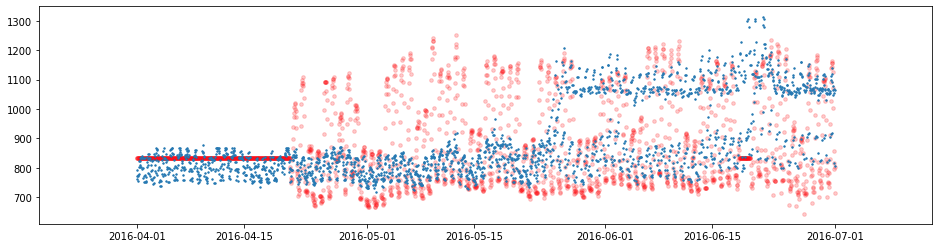

# Process insights

* I had to comment out some code, as well as embed many of the plots manually instead of letting the code do it, as otherwise committing this kernel would have taken too long. In addition, I even had to comment some code that would not have taken long (the Sequential test and the LightGBM test) as the kernel ran out of memory during them, crashing the commit. A cleaner solution would have been to split the project into two or three kernels, as described [here](https://www.kaggle.com/c/ashrae-energy-prediction/discussion/114941).